K-Means Clustering 

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# load dataset
df = pd.read_csv('Cleaned_News_Articles_Final2.csv')
df = df[['headline']]

headlines = df['headline'].tolist()

# TF-IDF Vetorizer
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(headlines)

# kmeans clustering
num_clusters = 3  # nega posi neutral
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# assign sentiment labels to clusters
cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

# clusters and their labels
df['cluster_label'] = kmeans.labels_

label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['cluster_label'])

# print(df[['headline', 'sentiment']])

# decode back to negative, positive, neutral
inverse_mapping = {0: 'negative', 1: 'positive', 2: 'neutral'}
df['sentiment'] = df['sentiment'].map(inverse_mapping)

df.drop(columns=['cluster_label'], inplace=True)

# print(df[['headline', 'sentiment']])


c:\Users\ChokJoe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [2]:
print(df['sentiment'].value_counts())

negative    37192
neutral      2546
positive     2057
Name: sentiment, dtype: int64


In [3]:
df.to_csv('kmeans_without_augmented.csv', index=False)

Visualize PCA 

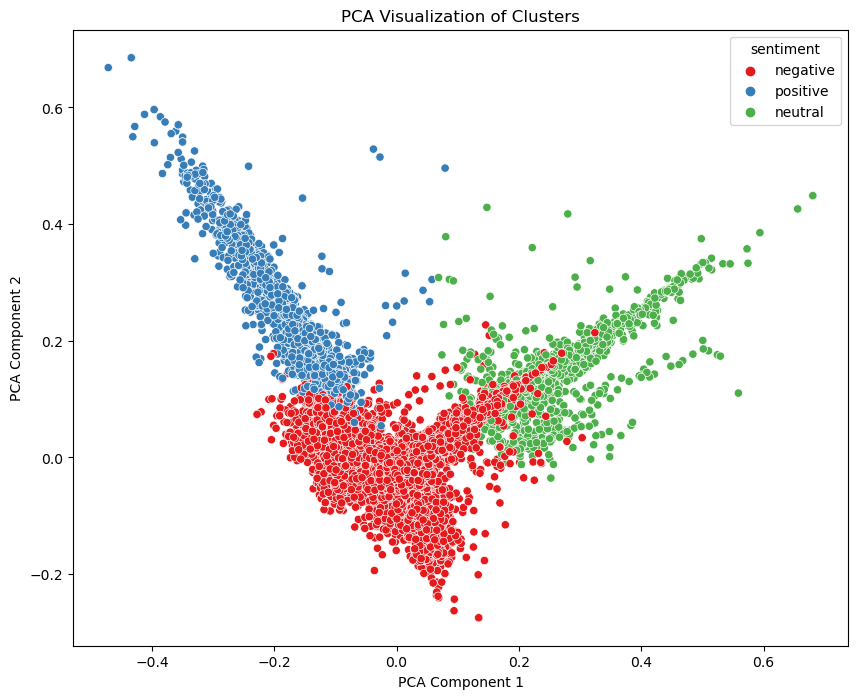

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# reduce dimensionality using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['sentiment'], palette='Set1', legend='full')
plt.title('PCA Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


Silhouette Score Before Augmented

In [5]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
clusters = kmeans.fit_predict(X_pca)

silhouette_avg = silhouette_score(X_pca, clusters)
db_index = davies_bouldin_score(X_pca, clusters)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {db_index}')


c:\Users\ChokJoe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.7775734823424247
Davies-Bouldin Index: 0.4460467273393376


Augmented Data with 4 Techniques

In [6]:
import pandas as pd

# load the data 
file_path = "kmeans_without_augmented.csv"
data = pd.read_csv(file_path)

In [7]:
import pandas as pd
import nlpaug.augmenter.word as naw
from tqdm import tqdm
import random
import os
import nltk

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# load dataset
file_path = 'kmeans_without_augmented.csv'
data = pd.read_csv(file_path)

# minority sentiment
minority_labels = {
    "neutral": 2546,
    "positive": 2057,
}

# technique to augmented
aug = naw.ContextualWordEmbsAug(
    model_path='distilbert-base-uncased', action="substitute")

aug2 = naw.ContextualWordEmbsAug(
    model_path='roberta-base', action="substitute")

aug_insert = naw.ContextualWordEmbsAug(
    model_path='roberta-base', action="insert")

aug_synonym = naw.SynonymAug(aug_src='wordnet')

# lists to store augmented data
augmented_summaries = []
multilabels = []

for _, row in tqdm(data.iterrows(), total=len(data)):
    if isinstance(row['sentiment'], str):
        augmented_labels = row['sentiment'].split(',') 
        augmented_labels_filtered = [label.strip() for label in augmented_labels if label.strip() in minority_labels]
        
        if augmented_labels_filtered:
            # augment the summary for in headline
            augmented_summary = aug.augment(row['headline'])
            augmented_summary2 = aug2.augment(row['headline'])
            augmented_summary_insert = aug_insert.augment(row['headline'])
            augmented_summary_synonym = aug_synonym.augment(row['headline'])
            
            # append to the lists
            augmented_summaries.extend([augmented_summary, augmented_summary2, augmented_summary_insert, augmented_summary_synonym])
            multilabels.extend([row['sentiment']] * 4)

augmented_df = pd.DataFrame({'headline': augmented_summaries, 'sentiment': multilabels})

data_augmented_path = 'kmeans_with_augmented.csv'
augmented_df.to_csv(data_augmented_path, index=False)


100%|██████████| 41795/41795 [46:29<00:00, 14.98it/s]  


Check total of augmented

In [8]:
data_augmented_path = "kmeans_with_augmented.csv"
augmented_df = pd.read_csv(data_augmented_path)
augmented_df['sentiment'].value_counts()

neutral     10184
positive     8228
Name: sentiment, dtype: int64

Combine Augmented data & witthout Augmented Data

In [9]:
import pandas as pd

# combine data
csv_files = ['kmeans_with_augmented.csv', 'kmeans_without_augmented.csv']

# initialize an empty list
dfs = []

# append its data to the list
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

combined_data = pd.concat(dfs, ignore_index=True)

# sort the combined data in sentiment column
sorted2_data = combined_data.sort_values(by='sentiment')

final_aug_path = "final_kmeans.csv"
sorted2_data.to_csv(final_aug_path, index=False)

sorted2_data['sentiment'].value_counts()

negative    37192
neutral     12730
positive    10285
Name: sentiment, dtype: int64

Remove square brackets, single quotes, and double quotes

In [10]:
import pandas as pd

input_file = 'final_kmeans.csv'
output_file = 'final_kmeans.csv'

# load dataset
df = pd.read_csv(input_file)

# remove square brackets, single quotes, double quotes
df['headline'] = df['headline'].str.replace(r"[\[\]\"']", '', regex=True)

df.to_csv(output_file, index=False)

Downsampling to select each sentiment 10000 data (Balanced)

In [11]:
import pandas as pd

# load dataset
df = pd.read_csv('final_kmeans.csv')  

# select 10000 data for each sentiment
lower_limit = 100
upper_limit = 10000

# grp the data by sentiment and perform downsampling within each grp
downsampled_data = df.groupby('sentiment').apply(lambda x: x.sample(n=min(upper_limit, max(lower_limit, len(x))), random_state=42))

downsampled_data = downsampled_data.reset_index(drop=True)

downsampled_data.to_csv('final_kmeans_subset.csv', index=False)  # The 'index=False' parameter is used to not write row indices

downsampled_data['sentiment'].value_counts()

negative    10000
neutral     10000
positive    10000
Name: sentiment, dtype: int64

Silhouette Score After Augmented

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

# load dataset
df = pd.read_csv('final_kmeans_subset.csv')  

# encode sentiment labels
label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['sentiment'])

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['headline'])

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

silhouette_avg = silhouette_score(X, clusters)
print(f'Silhouette Score: {silhouette_avg}')


c:\Users\ChokJoe\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.004177395884459106


ML Models